In [453]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

# Week 6

In [132]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz

--2022-03-24 15:50:46--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz
Resolving deepyeti.ucsd.edu... 169.228.63.50
Connecting to deepyeti.ucsd.edu|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5339013 (5.1M) [application/octet-stream]
Saving to: 'Software_5.json.gz.2'

Software_5.json.gz. 100%[===================>]   5.09M  1.25MB/s    in 4.7s    

2022-03-24 15:50:51 (1.08 MB/s) - 'Software_5.json.gz.2' saved [5339013/5339013]



In [458]:
### load the data
data = []
with gzip.open('Software_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)

print("Obervations in the whole dataset:", len(df))

Obervations in the whole dataset: 12805


Clean the dataset from missing ratings and duplicates (cases where the same user has rated the same item multiple times) if any.

In [457]:
df = df.sort_values(by=['reviewerID', 'asin', 'unixReviewTime'])
cleaned_dataset = df.dropna(subset=['overall']).drop_duplicates(subset=['reviewerID', 'asin'], keep = 'last').reset_index(drop=True)
print("Obervations in the cleaned dataset:", len(cleaned_dataset))

Obervations in the cleaned dataset: 11884


create a test set by extracting the latest positively rated item (rating ≥ 4) by each user. Remove users that do not appear in the training set.


In [459]:
cleaned_dataset = cleaned_dataset.sort_values(by=['reviewerID', 'unixReviewTime']).reset_index(drop=True)
# extracting the latest (in time) positively rated item (rating  ≥4 ) by each user. 
test_data_pre = cleaned_dataset[cleaned_dataset.overall >= 4.0].drop_duplicates(subset=['reviewerID'], keep='last')
# generate training data
training_data = cleaned_dataset.drop(test_data_pre.index)
print("Observations in training set:", len(training_data))

# Remove users that do not appear in the training set.
user_in_training = test_data_pre['reviewerID'].isin(training_data['reviewerID'])
test_data = test_data_pre[user_in_training]
print("Observations in test set:", len(test_data))

Observations in training set: 10171
Observations in test set: 1711


distribution of ratings per user




In [531]:
number_of_rating_user = training_data.groupby(['reviewerID']).count()
print("summary statistics of ratings per user:")
number_of_rating_user.overall.describe()

summary statistics of ratings per user:


count    1824.000000
mean        5.576206
std         3.488828
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        51.000000
Name: overall, dtype: float64

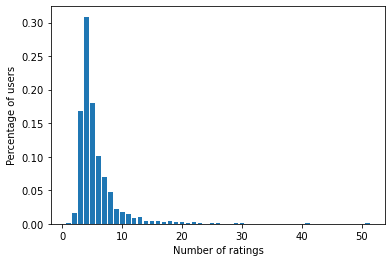

In [537]:
import matplotlib.pyplot as plt
from collections import Counter

# plot histogram
statistics_user = training_data.reviewerID.value_counts().tolist()
x = np.unique(statistics_user)
counted = Counter(statistics_user)
y = []
for key in x:
    tmp = counted[key] / len(statistics_user)
    y.append(tmp)
plt.bar(x, y)
plt.xlabel("Number of ratings")
plt.ylabel("Percentage of users")
plt.savefig("distributions_user.pdf")
plt.show()

distribution of ratings per item

In [461]:
number_of_rating_item = training_data.groupby(['asin']).count()
print("summary statistics of ratings per item:")
number_of_rating_item.overall.describe()

summary statistics of ratings per item:


count    800.000000
mean      12.713750
std       16.234801
min        1.000000
25%        5.000000
50%        9.500000
75%       17.000000
max      226.000000
Name: overall, dtype: float64

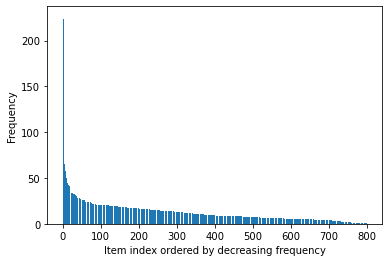

In [538]:
# a barplot of the number of ratings ordered by decreasing frequency
statistics_item = training_data.asin.value_counts()
plt.bar(np.arange(len(statistics_item)), statistics_item)
plt.xlabel("Item index ordered by decreasing frequency")
plt.ylabel("Frequency")
plt.savefig("distributions_item.pdf")
plt.show()

 the top 5 most popular items

In [465]:
popular_rating = number_of_rating_item.overall.sort_values(ascending=False)
popular_items = pd.DataFrame(data = popular_rating.values, index = popular_rating.index, columns=["rated times"])
user_item_training = training_data.pivot('reviewerID', 'asin', 'overall')
user_item_training_mean = user_item_training.mean(axis = 0)
for item in popular_items.index.values:
    popular_items.loc[item, "mean rating"] = user_item_training_mean.loc[item]

popular_items.sort_values(by=["rated times", "mean rating"], ascending=False).head()

,rated times,mean rating
asin,,
B0001FS9NE,226,4.929204
B000050ZRE,226,4.929204
B0000AZJY6,224,4.928571
B00EZPXYP4,91,4.384615
B00F8K9MZQ,66,4.318182


The metadata file contains information of all items in the complete dataset, not only the 5-core subset. You need to filter out all items that are not included in the training and/or test sets after steps (2) and (3).

In [140]:
# I did this part in Week 9

# Week 7

In [466]:
from surprise import Reader
from surprise import Dataset
import numpy as np

In [467]:
reader = Reader(rating_scale=(1, 5))
training = Dataset.load_from_df(training_data[['reviewerID', 'asin', 'overall']], reader)

#### Define a user-based neighborhood model that takes into account the mean rating of each user.

Use 3-fold cross-validation on the training set to tune the hyperparameters of the chosen model (similarity measure and number of neighbors for the neighborhood-based model)

In [468]:
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV

similarities = ['cosine', 'msd', 'pearson', 'pearson_baseline']
k_set = [1, 5, 10, 15, 20] # values of k

param_grid = {'k': k_set,
              'sim_options': {'name': similarities,
                              'user_based': [True]
                            }}
gs_knn = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
gs_knn.fit(training)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done 

Report the optimal hyperparameters together with the corresponding validation Root Mean Square Errors averaged over the 3 folds.

In [469]:
print("Optimal hyperparameters:", gs_knn.best_params['rmse'])
print("Root Mean Square Errors averaged over the 3 folds:", gs_knn.best_score['rmse'])
# get optimal hyperparameters
best_k = gs_knn.best_params['rmse']['k']
best_sim_options = gs_knn.best_params['rmse']['sim_options']

Optimal hyperparameters: {'k': 5, 'sim_options': {'name': 'pearson', 'user_based': True}}
Root Mean Square Errors averaged over the 3 folds: 1.213551003412549


Run the models with the optimal hyperparameters to the whole training set.

In [483]:
trainset_nb = training.build_full_trainset()
model_nb = KNNWithMeans(k=best_k, sim_options=best_sim_options)
model_nb.fit(trainset_nb)
testset_nb = trainset_nb.build_anti_testset()
predictions_nb = model_nb.test(testset_nb)

Computing the pearson similarity matrix...
Done computing similarity matrix.


5

#### Define an SVD model with user and item biases that uses Stochastic Gradient Descend (SGD) to estimate the low-rank matrix based on only observed ratings.

Use 3-fold cross-validation on the training set to tune the hyperparameters of the chosen models (number of latent factors and number of epochs for the latent factor model)

In [471]:
from surprise import SVD

n_factors_set = np.arange(10, 51, 10) 
n_epochs_set = np.arange(100, 501, 100)

param_grid = {'n_epochs': n_epochs_set, 'n_factors': n_factors_set}
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs_svd.fit(training)

Report the optimal hyperparameters together with the corresponding validation Root Mean Square Errors averaged over the 3 folds.

In [484]:
print("Optimal hyperparameters:", gs_svd.best_params['rmse'])
print("Root Mean Square Errors averaged over the 3 folds:", gs_svd.best_score['rmse'])

best_factors = gs_svd.best_params['rmse']['n_factors']
best_epochs = gs_svd.best_params['rmse']['n_epochs']

Optimal hyperparameters: {'n_epochs': 100, 'n_factors': 10}
Root Mean Square Errors averaged over the 3 folds: 1.1344357969390773


Run the models with the optimal hyperparameters to the whole training set.

In [485]:
trainset = training.build_full_trainset()
model_lf = SVD(n_factors = best_factors, n_epochs = best_epochs, random_state = 0)
model_lf.fit(trainset)
testset_lf = trainset.build_anti_testset()
predictions_lf = model_lf.test(testset_lf)

Use the final models to rank the non-rated items for each user.

In [149]:
# I did this part in Week 8, because we need to remove users of predictions who are in the training set and are not in the test set.

# Week 8

Measure the error of the system’s predicted ratings for Software products

In [486]:
from surprise import accuracy

pred_nb_list = predictions_nb
pred_lf_list = predictions_lf
# Detect users from training set that are not in test
nb_users = set([pred.uid for pred in pred_nb_list])
lf_users = set([pred.uid for pred in pred_lf_list])
nb_users_in_pred_but_not_in_test = list(nb_users.difference(set(test_data['reviewerID'])))
lf_users_in_pred_but_not_in_test = list(lf_users.difference(set(test_data['reviewerID'])))
assert nb_users_in_pred_but_not_in_test == lf_users_in_pred_but_not_in_test
print(f"There are {len(lf_users_in_pred_but_not_in_test)} users in the training set that are not in the test set.")

# Remove these users' predictions for evaluation
pred_nb_list_removed = [pred for pred in pred_nb_list if pred.uid not in nb_users_in_pred_but_not_in_test]
pred_lf_list_removed = [pred for pred in pred_lf_list if pred.uid not in lf_users_in_pred_but_not_in_test]
assert len(pred_nb_list_removed) == len(pred_lf_list_removed)
print(f"Evaluating the systems with {len(pred_nb_list_removed)} predictions for users in the test split.")

There are 113 users in the training set that are not in the test set.
Evaluating the systems with 1359246 predictions for users in the test split.


In [487]:
print("RMSE for Neighborhood based Collaborative Filtering: {:.3f}".format(accuracy.rmse(pred_nb_list_removed)))
print("RMSE for Latent Factor based Collaborative Filtering: {:.3f}".format(accuracy.rmse(pred_lf_list_removed)))

RMSE: 0.9793
RMSE for Neighborhood based Collaborative Filtering: 0.979
RMSE: 0.8193
RMSE for Latent Factor based Collaborative Filtering: 0.819


Generate the top-k (with k = 5) recommendation for each test user

In [488]:
from collections import defaultdict

def transfer_to_user_item_rating(pred_list):
    # map users to their massages (iid, est)
    user_item_rating = defaultdict(list)
    for uid, iid, _, est, _ in pred_list:
        user_item_rating[uid].append((iid, est))
    # {uid: (iid, est)}
    return user_item_rating

def top_k_recommendations(n, user_item_rating):
    # Then sort the predictions for each user and retrieve the k highest ones.
    top_n = defaultdict(list)
    for uid, user_ratings in user_item_rating.items():
        # rank the non-rated items for each user
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        # {uid: (iid, est)} -> top-n
        top_n[uid] = user_ratings[:n]

    return top_n

In [489]:
user_item_test = test_data.pivot('reviewerID', 'asin', 'overall')
user_item_test = user_item_test.fillna(0)

# compute P@k for one user
def precision_at_k(k, user_ratings):
    n_rel = sum((relevant) for (_, _, relevant) in user_ratings[:k])
    return n_rel / k

# compute RR@k for one user
def RR_at_k(k, user_ratings):
    for i in range(k):
        _, _, relevant = user_ratings[i]
        if relevant == 1:
            return 1.0 / (i+1)
    return 0.0

def total_relevant(user_ratings):
    return sum((relevant) for (_, _, relevant) in user_ratings)

def transfer_to_user_item_rating_relevant(pred_list):
    # map users to their messages
    user_item_rating = defaultdict(list)
    for pred in pred_list:
        true_rating = user_item_test.loc[pred.uid, pred.iid] if pred.iid in list(user_item_test.columns) else 0
        relevant = 1 if true_rating >= 4.0 else 0
        user_item_rating[pred.uid].append((pred.iid, pred.est, relevant))
    # {uid: [(iid, est, relevant)]}
    return user_item_rating

def compute_metrics(k, user_item_rating):
    precisions = dict() # precision
    ap = dict() # average precision
    rr = dict() # reciprocal rank
    for uid, user_ratings in user_item_rating.items():
        # rank the non-rated items for each user
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        precisions[uid] = precision_at_k(k, user_ratings)
        ap[uid] = (sum((precision_at_k(i, user_ratings)*user_ratings[i-1][2]) for i in range(1, k+1)) / total_relevant(user_ratings)) if total_relevant(user_ratings) != 0 else 0
        rr[uid] = RR_at_k(k, user_ratings)

    return sum(prec for prec in precisions.values()) / len(precisions), sum(prec for prec in ap.values()) / len(ap), sum(prec for prec in rr.values()) / len(rr)

In [490]:
user_item_rating_nb_relevant = transfer_to_user_item_rating_relevant(pred_nb_list_removed)
user_item_rating_lf_relevant = transfer_to_user_item_rating_relevant(pred_lf_list_removed)

k_set = [5]
print("Metrics for Neighborhood based CF:")
for k in k_set:
    p_at_k_nb, map_at_k_nb, mrr_at_k_nb = compute_metrics(k, user_item_rating_nb_relevant)
    print(f"Averaged P@{k}:", round(p_at_k_nb, 3))
    print(f"MAP@{k}:", round(map_at_k_nb, 3))
    print(f"MRR@{k}:", round(mrr_at_k_nb, 3))

print("")

print("Metrics for Latent Factor based CF:")
for k in k_set:
    p_at_k_lf, map_at_k_lf, mrr_at_k_lf = compute_metrics(k, user_item_rating_lf_relevant)
    print(f"Averaged P@{k}:", round(p_at_k_lf, 3))
    print(f"MAP@{k}:", round(map_at_k_lf, 3))
    print(f"MRR@{k}:", round(mrr_at_k_lf, 3))

Metrics for Neighborhood based CF:
Averaged P@5: 0.004
MAP@5: 0.009
MRR@5: 0.009

Metrics for Latent Factor based CF:
Averaged P@5: 0.001
MAP@5: 0.002
MRR@5: 0.002


Compute the system’s hit rate averaged over the total number of users in the test set.

In [491]:
# compute HR@k for one user
def HR_at_k(k, user_ratings):
    for i in range(k):
        _, _, relevant = user_ratings[i]
        if relevant == 1:
            return 1.0
    return 0.0

def compute_hit_rate(k, user_item_rating):
    hr = dict() # hit rate
    for uid, user_ratings in user_item_rating.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        hr[uid] = HR_at_k(k, user_ratings)

    return sum(prec for prec in hr.values()) / len(hr) 

k_set = [5]
print("Hit Rate for Neighborhood based CF:")
for k in k_set:
    mhr_at_k_nb = compute_hit_rate(k, user_item_rating_nb_relevant)
    print(f"Hit Rate (top-{k}):", round(mhr_at_k_nb, 3))

print("")

print("Hit Rate for Latent Factor based CF:")
for k in k_set:
    mhr_at_k_lf = compute_hit_rate(k, user_item_rating_lf_relevant)
    print(f"Hit Rate (top-{k}):", round(mhr_at_k_lf, 3))

Hit Rate for Neighborhood based CF:
Hit Rate (top-5): 0.019

Hit Rate for Latent Factor based CF:
Hit Rate (top-5): 0.005


Ordered by the value of the column “unixReviewTime”, take the first and last users from the test set as reference and retrieve the 10 nearest neighbours of each reference user.

In [492]:
test_data_unix = test_data.sort_values(by=['unixReviewTime']).reset_index(drop=True)

first_user = test_data_unix.loc[0]['reviewerID']
last_user = test_data_unix.loc[len(test_data_unix) - 1]['reviewerID']

print("The first user: ", first_user)
print("The last user: ", last_user)

# get reference users' inner id
first_inner_uid = model_nb.trainset.to_inner_uid(first_user)
last_inner_uid = model_nb.trainset.to_inner_uid(last_user)

# get the 10 neighbors' inner id for the first user
first_10_inner_uid = model_nb.get_neighbors(first_inner_uid, k=10)
# get the 10 neighbors' inner id for the last user
last_10_inner_uid = model_nb.get_neighbors(last_inner_uid, k=10)

# get the raw id
first_10_raw_uid = [model_nb.trainset.to_raw_uid(inner_id) for inner_id in first_10_inner_uid]
last_10_raw_uid = [model_nb.trainset.to_raw_uid(inner_id) for inner_id in last_10_inner_uid]

print("10 nearest neighbors of the first user: ", first_10_raw_uid)
print("10 nearest neighbors of the last user: ", last_10_raw_uid)

The first user:  A2G0O4Y8QE10AE
The last user:  A2SACTIFMC5DXO
10 nearest neighbors of the first user:  ['A100UD67AHFODS', 'A105S56ODHGJEK', 'A1075X1Q4M3S78', 'A10C5CJK1YKGV0', 'A10CRW7XRJBJ2G', 'A10EIJM2C94M14', 'A10G3LHNAK4GEH', 'A10G4BPT5MGBHY', 'A10GU5NVTA5I67', 'A10NC6ZVVMBHNH']
10 nearest neighbors of the last user:  ['A23E9QQHJLNGUI', 'A2DV14M0BC6YY1', 'A100UD67AHFODS', 'A105S56ODHGJEK', 'A1075X1Q4M3S78', 'A10C5CJK1YKGV0', 'A10CRW7XRJBJ2G', 'A10EIJM2C94M14', 'A10G3LHNAK4GEH', 'A10G4BPT5MGBHY']


Print their rate history and analyse their predictions.

In [556]:
# get two clusters
cluster_first = [first_user] + first_10_raw_uid
cluster_last = [last_user] + last_10_raw_uid

first_rated_history = training_data[training_data['reviewerID'].isin(cluster_first)]
last_rated_history = training_data[training_data['reviewerID'].isin(cluster_last)]

user_item_first_cluster = first_rated_history.pivot('reviewerID', 'asin', 'overall')
for user in user_item_first_cluster.index.values:
    mean_rating_of_user = user_item_first_cluster.loc[user].mean()
    # fill in the average rating
    user_item_first_cluster.loc[user] = user_item_first_cluster.loc[user].fillna(mean_rating_of_user)

user_item_last_cluster = last_rated_history.pivot('reviewerID', 'asin', 'overall')
for user in user_item_last_cluster.index.values:
    mean_rating_of_user = user_item_last_cluster.loc[user].mean()
    # fill in the average rating
    user_item_last_cluster.loc[user] = user_item_last_cluster.loc[user].fillna(mean_rating_of_user)

print("Similarities between the first user's ratings and its 10 nearest neighbors' ratings:")
print(cosine_similarity([user_item_first_cluster.loc[first_user]], user_item_first_cluster.loc[first_10_raw_uid])[0])

print("")

print("Similarities between the last user's ratings and its 10 nearest neighbors' ratings:")
print(cosine_similarity([user_item_last_cluster.loc[last_user]], user_item_last_cluster.loc[last_10_raw_uid])[0])

Similarities between the first user's ratings and its 10 nearest neighbors' ratings:
[1.         0.97491908 1.         0.99362761 0.99513379 1.
 0.99931987 0.99199394 0.99975567 0.99701224]

Similarities between the last user's ratings and its 10 nearest neighbors' ratings:
[0.98379798 0.98604279 0.99720711 0.97853894 0.99720711 0.99249852
 0.99361356 0.99720711 0.99670568 0.99128762]


For those users or products that your model performs poorly on (RR ≤ 0.05), discuss the potential reasons behind.

In [521]:
def RR_poorly(user_item_rating):
    rr_list = dict() # reciprocal rank
    for uid in cluster_first + cluster_last: # set default value as 0
        rr_list[uid] = 0
    print("Total number of users in the two clusters:", len(rr_list))
    for uid, user_ratings in user_item_rating.items():
        # rank the non-rated items for each user
        if uid in cluster_first or uid in cluster_last:
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            user_rr = RR_at_k(len(user_ratings), user_ratings)
            if user_rr <= 0.05: # get poor rr
                rr_list[uid] = user_rr
            # if user_rr != 0.0:
            #     print(user_rr)
    return rr_list

rr_poorly_list = RR_poorly(user_item_rating_nb_relevant)
print("Total number of users whoes RR <= 0.05:", len(rr_poorly_list))
print("Print those users that the model performs poorly on (RR ≤ 0.05):")
print(rr_poorly_list)

Total number of users in the two clusters: 14
Total number of users whoes RR <= 0.05: 14
Print those users that the model performs poorly on (RR ≤ 0.05):
{'A2G0O4Y8QE10AE': 0.001594896331738437, 'A100UD67AHFODS': 0.004608294930875576, 'A105S56ODHGJEK': 0.002898550724637681, 'A1075X1Q4M3S78': 0.02040816326530612, 'A10C5CJK1YKGV0': 0.0022123893805309734, 'A10CRW7XRJBJ2G': 0.0025575447570332483, 'A10EIJM2C94M14': 0.0027100271002710027, 'A10G3LHNAK4GEH': 0.02127659574468085, 'A10G4BPT5MGBHY': 0.0024813895781637717, 'A10GU5NVTA5I67': 0.0038314176245210726, 'A10NC6ZVVMBHNH': 0.0013315579227696406, 'A2SACTIFMC5DXO': 0.009433962264150943, 'A23E9QQHJLNGUI': 0.0014814814814814814, 'A2DV14M0BC6YY1': 0}


# Week 9

In [498]:
import json
import pandas as pd
import gzip
import os
from urllib.request import urlopen

In [500]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Software.json.gz

--2022-03-29 11:33:34--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Software.json.gz
Resolving deepyeti.ucsd.edu... 169.228.63.50
Connecting to deepyeti.ucsd.edu|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15240894 (15M) [application/octet-stream]
Saving to: 'meta_Software.json.gz.3'

meta_Software.json. 100%[===================>]  14.53M  2.41MB/s    in 7.2s    

2022-03-29 11:33:42 (2.02 MB/s) - 'meta_Software.json.gz.3' saved [15240894/15240894]



In [501]:
import os
import sys
sys.path.append('../')
import pandas as pd

# Load the METADATA (ITEMS)
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('meta_Software.json.gz')
print("Total number of items in \'meta_Software\':", len(df))

# Discard duplicates
df = df.drop_duplicates(subset=['asin']).reset_index(drop=True)
print("Number of items after discard duplicate items:", len(df))

# Discard items that weren't rated by our subset of users
item_in_training = df['asin'].isin(training_data.append(test_data)['asin'])
df = df[item_in_training].reset_index(drop=True)
print("Number of items that were rated by users in training or testing data:", len(df))

Total number of items in 'meta_Software': 26790
Number of items after discard duplicate items: 21639
Number of items that were rated by users in training or testing data: 801


 Select the column “title” from the metadata (only for the products rated in our small subset of the dataset) and apply the following preprocessing to clean up the data: tokenization, transform to lowercase, remove stop- words3, stemming. Report the vocabulary size after preprocessing. 

In [522]:
import nltk
import string 
import re
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

df['clean_title']= df['title'].apply(lambda x: word_tokenize(x))

# the vocabulary size before the preprocessing.
vacabulary = set()

for word in df.clean_title.values:
    for voc in word:
        vacabulary.add(voc)

print("before preprocessing:", len(vacabulary))

before preprocessing: 967


[nltk_data] Downloading package punkt to /Users/wy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/wy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [523]:
stop_words = stopwords.words("english")

# stopwords removal
def remove_stopwords(text):
    output= [i for i in text if i not in stop_words]
    return output

def is_alpha(text):
    output = [i for i in text if i.isalpha()]
    return output

def to_lower(text):
    output= [i.lower() for i in text]
    return output

#defining the object for stemming
porter_stemmer = PorterStemmer()

def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

# print(df.clean_title)
df['clean_title']= df['clean_title'].apply(lambda x: to_lower(x))
df['clean_title']= df['clean_title'].apply(lambda x: is_alpha(x))
df['clean_title'] = df['clean_title'].apply(lambda x: remove_stopwords(x))
df['clean_title'] = df['clean_title'].apply(lambda x: stemming(x))

# the vocabulary size after the preprocessing.
vacabulary = set()
for word in df.clean_title.values:
    for voc in word:
        vacabulary.add(voc)
print("the vocabulary size after preprocessing:", len(vacabulary))
# print(df.clean_title)

the vocabulary size after preprocessing: 622


Represent each product in the TF-IDF vector space.

In [524]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

title_list = []
for text in df.clean_title.values:
    title_list.append(TreebankWordDetokenizer().detokenize(text))
tf_idf_matrix = tfidf_vectorizer.fit_transform(title_list)
tf_idf_array = tf_idf_matrix.toarray()

print("TF-IDF matrix shape:", tf_idf_array.shape)

TF-IDF matrix shape: (801, 618)


Represent each product using pretrained word embeddings

In [163]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [408]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def convert_sentence2vec(sentence):
    vectors = np.zeros((300,))
    count = 0
    for text in sentence:
        try: 
            vec = word2vec_vectors[text]
        except:
            pass
        else:
            count += 1
            vectors += vec
    result = vectors / count if count != 0 else np.zeros((300,))
    return result

word_vector = []
for text in df.clean_title.values:
    vector = convert_sentence2vec(text)
    word_vector.append(vector)

Explore the similarity between products within the vector spaces by computing their cosine similarity. Compare results obtained with TF-IDF and the word embeddings.

In [475]:
print("Cosine similarity between the first five products obtained with TF-IDF:")
print(cosine_similarity(tf_idf_array[:5]))

print("")

print("Cosine similarity between the first five products obtained with word embeddings:")
print(cosine_similarity(word_vector[:5]))

Cosine similarity of the first five products obtained with TF-IDF:
[[1.         0.40876432 0.38100113 0.         0.        ]
 [0.40876432 1.         0.66379832 0.         0.        ]
 [0.38100113 0.66379832 1.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]

Cosine similarity of the first five products obtained with word embeddings:
[[1.         0.49886109 0.48628955 0.64383875 0.3779223 ]
 [0.49886109 1.         0.82148934 0.40978907 0.32713615]
 [0.48628955 0.82148934 1.         0.43663537 0.3267278 ]
 [0.64383875 0.40978907 0.43663537 1.         0.41686391]
 [0.3779223  0.32713615 0.3267278  0.41686391 1.        ]]


# Week 10

Transform the “title” column of each product into a TF-IDF score or other numerical value, e.g., token-count based, that can represent the summaries.

In [541]:
# get tf-idf score of each item based on token-count 
def get_tf_idf_score(tf_idf_array):
    tf_idf_score = np.zeros(len(tf_idf_array))
    for i in range(len(tf_idf_array)):
        tf_idf_score[i] = sum(tf_idf_array[i] != 0)
    return tf_idf_score

tf_idf_score = get_tf_idf_score(tf_idf_array)
# print the first 5 items' tf-idf score
print(tf_idf_score[:5])

[ 5.  8. 10.  7.  4.]


After you represent each product in a vector space, represent each user in the same vector space. This can be done by using an average of the items the user rates. Instead of a simple average, a weighted average can be used, where the weight is the rating for the item by the user.

In [542]:
item_tf_idf_matrix = pd.DataFrame(index=df.asin.values, data=tf_idf_array)

def convert_2_same_vector_space():
    # map userID to the corresponding vector space
    same_vector_space = defaultdict(pd.DataFrame)
    for user in user_item_training.index.values:
        # get the rows where 'reviewerID == user'
        row_rated_by_users = training_data['reviewerID'].isin([user])
        # get items rated by the user
        items = training_data[row_rated_by_users].asin.values
        # get the user's ratings for these items
        ratings = user_item_training.loc[user, items].values
        # get items' feature vector from the TF-IDF vector
        product_vector = item_tf_idf_matrix.loc[items]
        # represent in the same vector space
        product_vector['overall'] = ratings
        same_vector_space[user] = product_vector
    return same_vector_space

def build_user_profile(same_vector_space):
    # map userID to the user's profile
    user_profile = defaultdict()
    for user, vector in same_vector_space.items():
        # get item feature vectors
        item_feature = vector.drop(['overall'], axis=1)
        # get the ratings for the items by the user
        rating = vector.overall.values
        # compute the weighted average
        user_profile[user] = np.mean(np.array(item_feature.multiply(rating, axis=0).values), axis=0)
    return user_profile

same_vector_space = convert_2_same_vector_space()
user_profile = build_user_profile(same_vector_space)

Calculate the user-item rating for an item by using a similarity metric between the user and the item. 

In [543]:
def compute_similarity_for_user_profile(user_profile):
    # map userID to cosine similarity
    similarity = defaultdict()
    for user, _ in same_vector_space.items():
        # get the rows where 'reviewerID == user'
        row_rated_by_users = training_data['reviewerID'].isin([user])
        # get items rated by the user
        rated_by_user = training_data[row_rated_by_users].asin.values
        # get items not rated by the user
        not_rated_by = item_tf_idf_matrix.drop(rated_by_user)
        temp = pd.DataFrame(index=not_rated_by.index, columns=['cosine_similarity'])
        # compute the cosine similarity between user prfile and items not rated by the user
        cosine_similarities = cosine_similarity([user_profile[user]], not_rated_by)
        temp['cosine_similarity'] = cosine_similarities[0]
        similarity[user] = temp
    return similarity

similarity_for_user_profile = compute_similarity_for_user_profile(user_profile)


Report Precision@5, MAP@5, MRR@5 and the hit rate using the test set.

In [544]:
def transfer_to_user_item_similarity_relevant(similarity):
    # map the predictions to each user.
    user_item_rating = defaultdict(list)
    for user, sim in similarity.items():
        if user not in list(user_item_test.index):  # very important part
            continue
        for iid in sim.index.values:
            true_rating = user_item_test.loc[user, iid] if iid in list(user_item_test.columns) else 0
            relevant = 1 if true_rating >= 4.0 else 0
            user_item_rating[user].append((iid, sim.loc[iid].values[0], relevant))
    # {uid: [(iid, similarity, relevant)]}
    return user_item_rating

# compute HR@k for one user
def HR_at_k(k, user_ratings):
    for i in range(k):
        _, _, relevant = user_ratings[i]
        if relevant == 1:
            return 1.0
    return 0.0

def compute_metrics(k, user_item_rating):
    hr = dict() # hit rate
    precisions = dict() # precision
    ap = dict() # average precision
    rr = dict() # reciprocal rank
    for uid, user_ratings in user_item_rating.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        hr[uid] = HR_at_k(k, user_ratings)
        precisions[uid] = precision_at_k(k, user_ratings)
        ap[uid] = (sum((precision_at_k(i, user_ratings)*user_ratings[i-1][2]) for i in range(1, k+1)) / total_relevant(user_ratings)) if total_relevant(user_ratings) != 0 else 0
        rr[uid] = RR_at_k(k, user_ratings)
    return sum(prec for prec in hr.values()) / len(hr), sum(prec for prec in precisions.values()) / len(precisions), sum(prec for prec in ap.values()) / len(ap), sum(prec for prec in rr.values()) / len(rr) 

user_item_similarity_cb = transfer_to_user_item_similarity_relevant(similarity_for_user_profile)

In [545]:
mhr_at_k, mp_at_k, map_at_k, mrr_at_k = compute_metrics(5, user_item_similarity_cb)
print(f"Average Precision@5: {round(mp_at_k, 3)} \nMAP@5: {round(map_at_k, 3)} \nMRR@5: {round(mrr_at_k, 3)} \nHit Rate (top-5): {round(mhr_at_k, 3)}")

Average Precision@5: 0.042 
MAP@5: 0.162 
MRR@5: 0.162 
Hit Rate (top-5): 0.208


# Week 11

**Weighted strategy** that re-ranks the items by combining the individual rankings from the two models with some aggregate function such as the sum, average, minimum or maximum.

In [546]:
# to rank the predictions/similarity of two models
def rank_scores(user_item_relevant):
    rank = dict()
    for uid, msg in user_item_relevant.items():
        item_est = pd.DataFrame(data=msg, columns=["asin", "score", "relevant"])
        # Normalize the scores
        item_est["norm_score"] = (item_est["score"] - item_est["score"].mean()) / item_est["score"].std() if item_est["score"].std() != 0 else 0
        # rank the scores
        rank[uid] = item_est.sort_values(by=["norm_score"], ascending=False).set_index("asin", drop=True)
    return rank

cf_prediction_rank = rank_scores(user_item_rating_nb_relevant)
cb_similarity_rank = rank_scores(user_item_similarity_cb)   

In [547]:
def rank_combination(cf_prediction_rank, cb_similarity_rank):
    rank = defaultdict(list)
    for uid, rank_msg_cf in cf_prediction_rank.items():
        rank_msg_cb = cb_similarity_rank[uid]
        for item in rank_msg_cf.index.values:
            norm_in_cf = rank_msg_cf.loc[item, "norm_score"]
            norm_in_cb = rank_msg_cb.loc[item, "norm_score"]
            relevant = rank_msg_cb.loc[item, "relevant"]
            alpha = 1
            beta = 1
            rank[uid].append((item, alpha*norm_in_cf + beta*norm_in_cb, relevant))

    # I did the following sort when computing MRR, MAP such metrics
    # for uid, rank_msg in rank.items():
    #     rank_msg.sort(key=lambda x: x[1], reverse=True)
    #     rank[uid] = rank_msg
    return rank

rank_combined_weighted = rank_combination(cf_prediction_rank, cb_similarity_rank)

**Switching strategy** that uses the recommendations from the collaborative filtering model for some users and the recommendations from the content- based model for other users chosen by a predefined condition.

In [548]:
def compute_RR(user_item_rating):
    rr_list = dict() # reciprocal rank
    for uid, user_ratings in user_item_rating.items():
        # rank the non-rated items for each user
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        rr_list[uid] = RR_at_k(len(user_ratings), user_ratings)
    return rr_list

# compute RR of each user
rr_nb = compute_RR(user_item_rating_nb_relevant)
rr_cb = compute_RR(user_item_similarity_cb)

def check_predefined_condition(userID):
    # check RR from two models
    return rr_cb[userID] >= rr_nb[userID]

def switching_strategy(cf_prediction_rank, cb_similarity_rank):
    rank = defaultdict(list)
    for uid, rank_msg_cf in cf_prediction_rank.items():
        rank_msg_cb = cb_similarity_rank[uid]
        if check_predefined_condition(uid):
            for item in rank_msg_cb.index.values:
                rank[uid].append((item, rank_msg_cb.loc[item, "norm_score"], rank_msg_cb.loc[item, "relevant"]))
        else:
            for item in rank_msg_cf.index.values:
                rank[uid].append((item, rank_msg_cb.loc[item, "norm_score"], rank_msg_cb.loc[item, "relevant"]))
                
    # I did the following sort when computing MRR, MAP such metrics
    # for uid, rank_msg in rank.items():
    #     rank_msg.sort(key=lambda x: x[1], reverse=True)
    #     rank[uid] = rank_msg
    return rank

rank_combined_switching = switching_strategy(cf_prediction_rank, cb_similarity_rank)

**Meta-level strategy** where a level of one model is used as input to the other model.

In [549]:
def user_non_rated_item():
    non_rated = dict()
    user_ids = user_item_training.index.values
    item_ids = user_item_training.columns.values
    for item in item_ids:
        # users rated the item and their ratings
        item_rated_by = pd.DataFrame(user_item_training[user_item_training[item] >= 0.0][item])
        for user in user_ids:
        # check if the user rated the item
            if user not in item_rated_by.index.values:
                # add to dict, so that we can predict
                non_rated[(user, item)] = item_rated_by
                
    return non_rated

non_rated = user_non_rated_item()

In [550]:
def add_cosine_similarity(non_rated):
    # compute the similarities
    non_rated_and_similarity = dict()
    for (user, item), msg in non_rated.items():
        users_rate_item = msg.index.values
        user_profiles = list(map(user_profile.get, users_rate_item))
        msg["similarity"] = cosine_similarity([user_profile[user]], user_profiles)[0]
        non_rated_and_similarity[(user, item)] = msg
    return non_rated_and_similarity

non_rated_and_similarity = add_cosine_similarity(non_rated)

In [551]:
def get_predictions(k, non_rated_and_similarity):
    # compute predictions
    predictions_user = defaultdict(list)
    for (user, item), msg in non_rated_and_similarity.items():
        three_most_simi = msg.sort_values(by=["similarity"], ascending=False).head(k)
        pred = three_most_simi[item].multiply(three_most_simi["similarity"]).sum(axis=0) / three_most_simi["similarity"].sum(axis=0) if three_most_simi["similarity"].sum(axis=0) != 0 else 0
        predictions_user[user].append((item, pred))
    return predictions_user

pred_hybrid = get_predictions(5, non_rated_and_similarity)

In [552]:
def check_relevent(pred_hybrid):
    # to check if the item is relevant
    pred_relevent = defaultdict(list)
    for user, pred_list in pred_hybrid.items():
        if user not in list(user_item_test.index):  # very important part
            continue
        for (item, pred) in pred_list:
            true_rating = user_item_test.loc[user, item] if item in list(user_item_test.columns) else 0
            relevant = 1 if true_rating >= 4.0 else 0
            pred_relevent[user].append((item, pred, relevant))
    return pred_relevent

rank_combined_meta = check_relevent(pred_hybrid)

Report Precision@5, MAP@5, MRR@5 and the hit rate using the test set.

In [553]:
mhr_at_k, mp_at_k, map_at_k, mrr_at_k = compute_metrics(5, rank_combined_weighted)
print("Metrics for hybrid recommender system with weighted strategy:")
print(f"Average Precision@5: {round(mp_at_k, 3)} \nMAP@5: {round(map_at_k, 3)} \nMRR@5: {round(mrr_at_k, 3)} \nHit Rate (top-5): {round(mhr_at_k, 3)}")

mhr_at_k, mp_at_k, map_at_k, mrr_at_k = compute_metrics(5, rank_combined_switching)
print("Metrics for hybrid recommender system with switching strategy:")
print(f"Average Precision@5: {round(mp_at_k, 3)} \nMAP@5: {round(map_at_k, 3)} \nMRR@5: {round(mrr_at_k, 3)} \nHit Rate (top-5): {round(mhr_at_k, 3)}")

mhr_at_k, mp_at_k, map_at_k, mrr_at_k = compute_metrics(5, rank_combined_meta)
print("Metrics for hybrid recommender system with meta-level strategy:")
print(f"Average Precision@5: {round(mp_at_k, 3)} \nMAP@5: {round(map_at_k, 3)} \nMRR@5: {round(mrr_at_k, 3)} \nHit Rate (top-5): {round(mhr_at_k, 3)}")

Metrics for hybrid recommender system with weighted strategy:
Average Precision@5: 0.041 
MAP@5: 0.16 
MRR@5: 0.16 
Hit Rate (top-5): 0.204
Metrics for hybrid recommender system with switching strategy:
Average Precision@5: 0.041 
MAP@5: 0.162 
MRR@5: 0.162 
Hit Rate (top-5): 0.207
Metrics for hybrid recommender system with meta-level strategy:
Average Precision@5: 0.026 
MAP@5: 0.127 
MRR@5: 0.127 
Hit Rate (top-5): 0.13
